# Fit Halo Mass from a Shear Catalog

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster. It uses several functionalities of the support `mock_data` module to produce datasets of increasing complexity. This notebook also demonstrates the bias introduced on the reconstructed mass by a naive fit, when the redshift distribution of the background galaxies is not properly accounted for in the model.

## Setup

First, we import some standard packages.

In [1]:
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl or nc (NumCosmo)
sys.path.append('./support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from numpy import random
from sampler import fitters

clmm.__version__

'0.3.0'

Next, we import `clmm`'s core modules.

In [2]:
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

In [3]:
import mock_data as mock

## Making mock data

For reproducibility:

In [4]:
np.random.seed(11)

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [5]:
mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
mock_cosmo_ccl = modeling.cclify_astropy_cosmo(mock_cosmo)

We now set some parameters for a mock galaxy cluster.

In [6]:
cosmo = mock_cosmo
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 10000
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate 3 galaxy catalogs:
- `ideal_data`: all background galaxies at the same redshift.
- `ideal_data_z`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data_z`: `ideal_data_z` + photoz errors + shape noise

In [7]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,0.8)
ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,'chang13')
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,'chang13', 
                                            shapenoise=0.05, 
                                            photoz_sigma_unscaled=0.05)

/pbs/home/c/ccombet/.conda/envs/mydesc/lib/python3.7/site-packages/clmm-0.3.0-py3.7.egg/clmm/modbackend/func_layer.py:433: UserWarning: Some source redshifts are lower than the cluster redshift. shear = 0 for those galaxies.


The galaxy catalogs are converted to a `clmm.GalaxyCluster` object and may be saved for later use.

In [8]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)
gc_object.save('ideal_GC.pkl')

cluster_id = "CL_ideal_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data_z)
gc_object.save('ideal_GC_z.pkl')

cluster_id = "CL_noisy_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)
gc_object.save('noisy_GC_z.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [9]:
cl1 = clmm.GalaxyCluster.load('ideal_GC.pkl') # all background galaxies at the same redshift
cl2 = clmm.GalaxyCluster.load('ideal_GC_z.pkl') # background galaxies distributed according to Chang et al. (2013)
cl3 = clmm.GalaxyCluster.load('noisy_GC_z.pkl') # same as cl2 but with photoz error and shape noise

print("Cluster info = ID:", cl2.unique_id, "; ra:", cl2.ra, "; dec:", cl2.dec, "; z_l :", cl2.z)
print("The number of source galaxies is :", len(cl2.galcat))

Cluster info = ID: CL_ideal_z ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


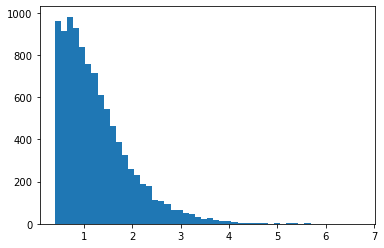

In [10]:
h = plt.hist(cl2.galcat['z'], bins=50)

## Deriving observables

### Computing shear

`clmm.polaraveraging.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster.

In [11]:
theta1, g_t1, g_x1 = cl1.compute_tangential_and_cross_components(geometry="flat")
theta2, g_t2, g_x2 = cl2.compute_tangential_and_cross_components(geometry="flat")
theta2, g_t3, g_x3 = cl3.compute_tangential_and_cross_components(geometry="flat")

### Radially binning the data

In [12]:
bin_edges = pa.make_bins(0.7, 4, 15, method='evenlog10width')

`clmm.polaraveraging.make_binned_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [13]:
profile1 = cl1.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
profile2 = cl2.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
profile3 = cl3.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

After running `clmm.polaraveraging.make_binned_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [14]:
for n in cl1.profile.colnames: cl1.profile[n].format = "%6.3e"
cl1.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 7.000e-01 7.534e-01  7.863e-01 5.315e-02 2.245e-04 -1.032e-18 2.214e-18 8.000e-01 2.177e-17 2.600e+01
 7.863e-01 8.328e-01  8.831e-01 4.956e-02 1.850e-04  4.449e-19 1.261e-18 8.000e-01 1.734e-17 4.100e+01
 8.831e-01 9.295e-01  9.920e-01 4.571e-02 1.446e-04  4.285e-18 1.719e-18 8.000e-01 3.140e-17 5.000e+01
 9.920e-01 1.055e+00  1.114e+00 4.142e-02 1.410e-04  1.084e-19 4.373e-19 8.000e-01 1.484e-17 5.600e+01
 1.114e+00 1.188e+00  1.251e+00 3.758e-02 1.202e-04 -9.663e-19 9.011e-19 8.000e-01 1.241e-17 8.000e+01
 1.251e+00 1.327e+00  1.406e+00 3.416e-02 1.072e-04  2.210e-19 6.668e-19 8.000e-01 1.121e-17 9.800e+01
 1.406e+00 1.492e+00  1.579e+00 3.071e-02 8.676e-05 -2.534e-19 4.560e-19 8.000e-01 1.933e-17 1.320e+02
 1.579e+00 1.682e+00  1.773e+00 2.740e-02 7.352e-05 -7.556e-19 3.852e-19 

We visualize the radially binned shear for the 3 configurations

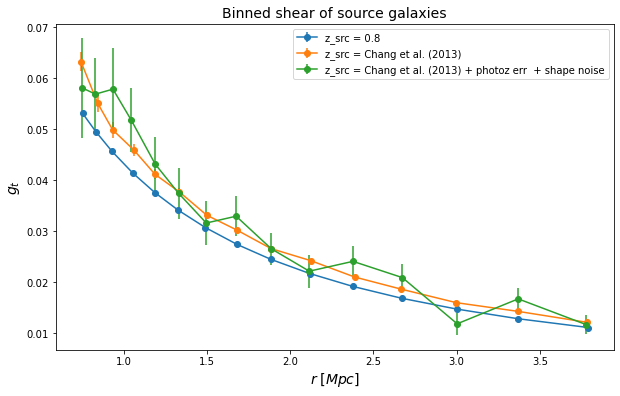

In [15]:
fig = plt.figure(figsize=(10, 6))


fsize = 14
fig.gca().errorbar(profile1['radius'], profile1['gt'], yerr=profile1['gt_err'], marker='o', label='z_src = 0.8')
fig.gca().errorbar(profile2['radius'], profile2['gt'], yerr=profile2['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013)')
fig.gca().errorbar(profile3['radius'], profile3['gt'], yerr=profile3['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013) + photoz err  + shape noise')

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)
plt.legend()

## Create the halo model

`clmm.modeling.predict_reduced_tangential_shear` supports various parametric halo profile functions, including `nfw`.
Beware that the `clmm.modeling` module works in units of $Mpc/h$, whereas the data is cosmology-independent, with units of $Mpc$.

In [16]:
# First define a CLMM modeling object to use with the NC or CCL backend

moo = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo_params_dict (mock_cosmo_ccl)
moo.set_concentration (4)

In [17]:
# model definition to be used with scipy.optimize.curve_fit
def shear_profile_model(r, logm, z_src):

    moo.set_mass (10.**logm)
    gt_model = moo.eval_reduced_shear (r*cosmo.h, cluster_z, z_src)
    return gt_model

### Fitting a halo mass - highlighting bias when not accounting for the source redshift distribution in the model

We estimate the best-fit mass using `scipy.optimize.curve_fit`.

Here, to build the model we make the WRONG assumption that the average shear in bin $i$ equals the shear at the average redshift in the bin; i.e. we assume that $\langle g_t\rangle_i = g_t(\langle z\rangle_i)$. This should not impact `cluster 1` as all sources are located at the same redshift. However, this yields a bias in the econstructed mass for `cluster 2` and `cluster 3`, where the sources followed the Chang et al. (2013) distribution.

In [18]:
# Cluster 1:  ideal data
popt1,pcov1 = fitters['curve_fit'](lambda r, logm:shear_profile_model(r, logm, profile1['z']), 
                    profile1['radius'], 
                    profile1['gt'], 
                    profile1['gt_err'], bounds=[13.,17.])
#popt1,pcov1 = spo.curve_fit(lambda r, logm:shear_profile_model(r, logm, profile1['z']), 
#                    profile1['radius'], 
#                    profile1['gt'], 
#                    sigma=profile1['gt_err'], bounds=[13.,17.])

m_est1 = 10.**popt1[0]
m_est_err1 =  m_est1 * np.sqrt(pcov1[0][0]) * np.log(10) # convert the error on logm to error on m

# Cluster 2:  ideal data with redshift distribution
popt2,pcov2 = fitters['curve_fit'](lambda r, logm:shear_profile_model(r, logm, profile2['z']), 
                    profile2['radius'], 
                    profile2['gt'], 
                    profile2['gt_err'], bounds=[13.,17.])

m_est2 = 10.**popt2[0]
m_est_err2 =  m_est2 * np.sqrt(pcov2[0][0]) * np.log(10) # convert the error on logm to error on m

# Cluster 3:  noisy data with redshift distribution
popt3,pcov3 = fitters['curve_fit'](lambda r, logm:shear_profile_model(r, logm, profile3['z']), 
                    profile3['radius'], 
                    profile3['gt'], 
                    profile3['gt_err'], bounds=[13.,17.])

m_est3 = 10.**popt3[0]
m_est_err3 =  m_est3 * np.sqrt(pcov3[0][0]) * np.log(10) # convert the error on logm to error on m



print(f'Best fit mass for cluster 1 = {m_est1:.2e} +/- {m_est_err1:.2e} Msun')
print(f'Best fit mass for cluster 2 = {m_est2:.2e} +/- {m_est_err2:.2e} Msun')
print(f'Best fit mass for cluster 3 = {m_est3:.2e} +/- {m_est_err3:.2e} Msun')

Best fit mass for cluster 1 = 1.00e+15 +/- 8.58e+10 Msun
Best fit mass for cluster 2 = 8.65e+14 +/- 2.31e+12 Msun
Best fit mass for cluster 3 = 8.82e+14 +/- 3.76e+13 Msun


As expected, the reconstructed mass is biased whenever the sources are not located at a single redshift as this was not accounted for in the model.

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model when using the average redshift of the catalog.

In [22]:
rr = np.logspace(-0.5, np.log10(5), 100)
moo.set_mass (m_est1)
gt_model1 = moo.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl1.galcat['z']))
moo.set_mass (m_est2)
gt_model2 = moo.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl2.galcat['z']))
moo.set_mass (m_est3)
gt_model3 = moo.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl3.galcat['z']))

We visualize that prediction of reduced tangential shear along with the data

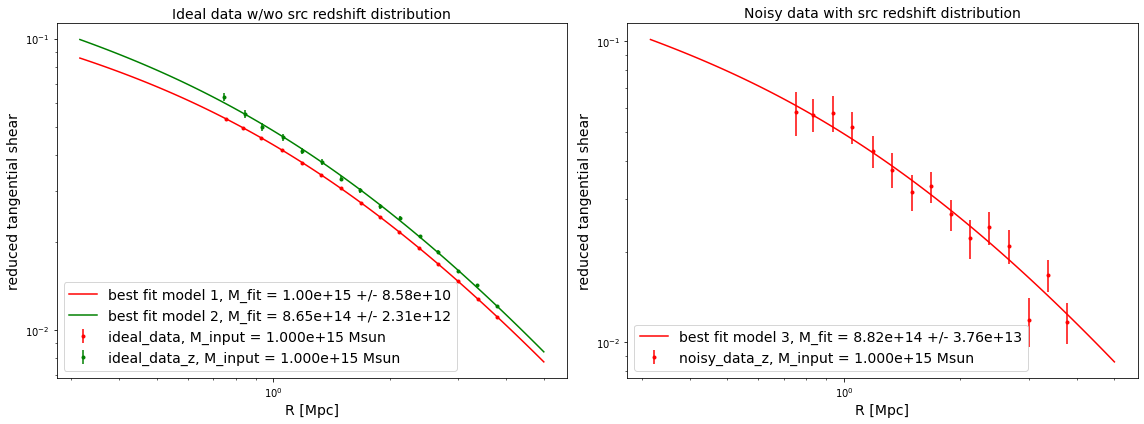

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].errorbar(profile1['radius'], profile1['gt'],profile1['gt_err'], color='red',
                 label='ideal_data, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model1,color='red',
             label='best fit model 1, M_fit = %.2e +/- %.2e' % (m_est1, m_est_err1))


axes[0].errorbar(profile2['radius'], profile2['gt'],profile2['gt_err'], color='green',
                  label='ideal_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model2, color='green',
               label='best fit model 2, M_fit = %.2e +/- %.2e' % (m_est2, m_est_err2))
axes[0].set_title('Ideal data w/wo src redshift distribution',fontsize=fsize)
axes[0].semilogx()
axes[0].semilogy()
axes[0].legend(fontsize=fsize)
axes[0].set_xlabel('R [Mpc]', fontsize=fsize)
axes[0].set_ylabel('reduced tangential shear', fontsize=fsize)

axes[1].errorbar(profile3['radius'], profile3['gt'],profile3['gt_err'], color='red',
                label='noisy_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[1].plot(rr, gt_model3,color='red',
             label='best fit model 3, M_fit = %.2e +/- %.2e' % (m_est3, m_est_err3))
axes[1].set_title('Noisy data with src redshift distribution',fontsize=fsize)
axes[1].semilogx()
axes[1].semilogy()
axes[1].legend(fontsize=fsize)
axes[1].set_xlabel('R [Mpc]', fontsize=fsize)
axes[1].set_ylabel('reduced tangential shear', fontsize=fsize)

fig.tight_layout()